<a href="https://colab.research.google.com/github/ateachment/MoodleSearch/blob/main/moodleSearch_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lemmatisierung deutscher Sprache: 
https://nickyreinert.de/blog/2020/12/09/einfuehrung-in-stemming-und-lemmatisierung-deutscher-texte-mit-python/

Installation von HanoverTagger (wird :

In [74]:
pip install HanTa # install lemmatizer of german language

In [75]:
import requests
import bs4
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from HanTa import HanoverTagger as ht
hannover = ht.HanoverTagger('morphmodel_ger.pgz')

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # We will use this later to decide how similar two sentences are

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
stop = nltk.corpus.stopwords.words('german')
# Add a few more stop words we would like to remove here
stop.append('daher')
stop.append('vieler')
stop.append('vielen')
stop.append('usw')
stop.append('bzw')
stop.append('etc')
stop.append('d.h.')
stop.append('u.a')
stop.append('z.b')
stop.append('--')
stop.append('-')
stop.append('``')
stop.append("''")
stop

['aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders',
 'auch',
 'auf',
 'aus',
 'bei',
 'bin',
 'bis',
 'bist',
 'da',
 'damit',
 'dann',
 'der',
 'den',
 'des',
 'dem',
 'die',
 'das',
 'dass',
 'daß',
 'derselbe',
 'derselben',
 'denselben',
 'desselben',
 'demselben',
 'dieselbe',
 'dieselben',
 'dasselbe',
 'dazu',
 'dein',
 'deine',
 'deinem',
 'deinen',
 'deiner',
 'deines',
 'denn',
 'derer',
 'dessen',
 'dich',
 'dir',
 'du',
 'dies',
 'diese',
 'diesem',
 'diesen',
 'dieser',
 'dieses',
 'doch',
 'dort',
 'durch',
 'ein',
 'eine',
 'einem',
 'einen',
 'einer',
 'eines',
 'einig',
 'einige',
 'einigem',
 'einigen',
 'einiger',
 'einiges',
 'einmal',
 'er',
 'ihn',
 'ihm',
 'es',
 'etwas',
 'euer',
 'eure',
 'eurem',
 'euren',
 'eurer',
 'eures',
 'für',
 'gegen',
 'gewesen',
 'hab',
 'habe',
 'haben',
 'hat',
 'hatte',
 'hatten',
 '

# Web Crawling

In [77]:
base_url = 'https://eick-at.de/moodle/course/view.php?id=19'  # URL of the Moodle Course
r = requests.get(base_url)                                              # Http Request 
r


<Response [200]>

In [78]:
#`r.text` contains the raw HTML returned when we made our GET request earlier. 
#`'html5lib'` tells BeautifulSoup that it is reading HTML information. 
soup = bs4.BeautifulSoup(r.text,'html5lib')



In [79]:
headers = []                         
for url in soup.findAll("h3"):      # find sections
    headers.append(url)

In [80]:
headers

[<h3 class="sectionname" id="sectionid-165-title"><span><a href="https://eick-at.de/moodle/course/view.php?id=19#section-0">Allgemeine Informationen</a></span></h3>,
 <h3 class="sectionname" id="sectionid-166-title"><span><a href="https://eick-at.de/moodle/course/view.php?id=19#section-1">Einführung</a></span></h3>,
 <h3 class="sectionname" id="sectionid-167-title"><span><a href="https://eick-at.de/moodle/course/view.php?id=19#section-2">Datenexploration</a></span></h3>,
 <h3 class="sectionname" id="sectionid-168-title"><span><a href="https://eick-at.de/moodle/course/view.php?id=19#section-3">Entwicklungsumgebung</a></span></h3>,
 <h3 class="sectionname" id="sectionid-169-title"><span><a href="https://eick-at.de/moodle/course/view.php?id=19#section-4">Quellen</a></span></h3>,
 <h3 class="sectionname" id="sectionid-170-title"><span><a href="https://eick-at.de/moodle/course/view.php?id=19#section-5">KI-Domainen</a></span></h3>,
 <h3 class="sectionname" id="sectionid-171-title"><span><a h

In [81]:
def processText(txt):
  tokenized = nltk.tokenize.word_tokenize(txt)
  #print(tokenized)
  hannovered = [hannover.analyze(word)[0] for word in tokenized]
  #print(hannovered)
  processed = [w.lower() for w in hannovered if w not in stop]
  #print(processed)
  return processed


In [82]:
data = []                                      
for header in headers:                          # iterate sections
  # print(header)
  link = header.find('a').attrs['href']         # extract link of section
  txt = header.get_text()                       # extract text of section
  processed = processText(txt)                  # nlp of section text
  entry = [link, processed]                     # list entry with link and processed text
  print(entry)
  data.append(entry)                            # append entry in list data (nested lists)

  listTags = header.find_next_sibling('ul')     # pages, tasks, links ..
  for li in listTags:
    #print(li)
    link = li.find('a')
    txt2 = link.get_text().replace("Page","").replace("URL","").replace("Assignment","")
    if not("URL" in link.get_text()):
      link = link.attrs['href'] 
      
      r = requests.get(link)                    # Seiten aufrufen
      soup2 = bs4.BeautifulSoup(r.text,'html5lib')
      header2 = soup2.find('h2')                # Überschrift
      #print(header2)
      paragraphs = header2.find_all_next('p')   # Absätze
      txt = ""
      for paragraph in paragraphs:
        txt += paragraph.get_text()
      txt2 += txt
      #print(link,txt2)
      processed =processText(txt2)
      entry = [link, processed]
      print(entry)
      data.append(entry)



['https://eick-at.de/moodle/course/view.php?id=19#section-0', ['allgemein', 'information']]
['https://eick-at.de/moodle/course/view.php?id=19#section-1', ['einführung']]
['https://eick-at.de/moodle/mod/page/view.php?id=1358', ['künstlich', 'intelligenz', 'künstlich', 'intelligenz', 'ki', 'engl', 'artificial', 'intelligence', 'ai', 'bezeichnen', 'teilgebiet', 'informatik', 'automatisierung', 'intelligent', 'verhalten', 'maschinell', 'lernen', 'befassen', 'begriff', 'verwendet', 'obwohl', 'zugrunde', 'liegend', 'definition', 'intelligenz', 'durchaus', 'umstritten', 'ki', 'durchaus', 'traditionell', 'art', 'realisert', 'lange', 'reihe', 'wenn-dann-anweisung', 'einfach', 'kontrollstrukturen', 'bzw', 'regel', 'aneinander', 'reihen', 'expertensystem', 'lassen', 'z.b', 'krankheit', 'anhand', 'symptom', 'diagnostizieren', 'ki', 'lassen', 'gewissen', 'grenze', 'klassisch', 'programmierung', 'erreichen', 'allerdings', 'algorithmen', 'je', 'anforderung', 'kompliziert', 'traditionell', 'programmie

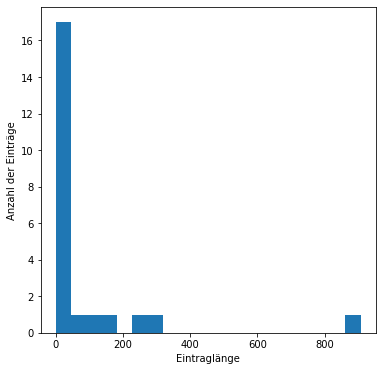

In [83]:
import matplotlib.pyplot as plt
def plot_hist(data):
    entry_lengths = [len(entry[1]) for entry in data]
    fig = plt.figure(figsize=(6, 6)) 
    plt.xlabel('Eintraglänge')
    plt.ylabel('Anzahl der Einträge')
    plt.hist(entry_lengths, bins=20)
    plt.show()
    return entry_lengths
entry_lengths = plot_hist(data)

Bag of words

In [84]:
# calculate frequency of words
def map_book(hash_map, tokens):
    if tokens is not None:
        for word in tokens:
            # Word Exist?
            if word in hash_map:
                hash_map[word] = hash_map[word] + 1
            else:
                hash_map[word] = 1

        return hash_map
    else:
        return None
        
def make_hash_map(data):  
    hash_map = {}
    for entry in data:
        hash_map = map_book(hash_map, entry[1])
    return hash_map


# define a function frequent_vocab with the following input: word_freq and max_features
def frequent_vocab(word_freq, max_features): 
    counter = 0  #initialize counter with the value zero
    vocab = []   # create an empty list called vocab
    # list words in the dictionary in descending order of frequency
    for key, value in sorted(word_freq.items(), key=lambda item: (item[1], item[0]), reverse=True): 
       #loop function to get the top (max_features) number of words
        if counter<max_features: 
            vocab.append(key)
            counter+=1
        else: break
    return vocab

In [85]:
hash_map = make_hash_map(data) #create hash map (words and frequency) from tokenized dataset

vocab=frequent_vocab(hash_map, 1000)  # adjust second Parameter
print(hash_map)
print(vocab)

{'allgemein': 1, 'information': 2, 'einführung': 1, 'künstlich': 15, 'intelligenz': 9, 'ki': 8, 'engl': 5, 'artificial': 2, 'intelligence': 2, 'ai': 1, 'bezeichnen': 2, 'teilgebiet': 2, 'informatik': 1, 'automatisierung': 1, 'intelligent': 2, 'verhalten': 1, 'maschinell': 13, 'lernen': 11, 'befassen': 1, 'begriff': 7, 'verwendet': 2, 'obwohl': 1, 'zugrunde': 1, 'liegend': 1, 'definition': 1, 'durchaus': 3, 'umstritten': 1, 'traditionell': 2, 'art': 3, 'realisert': 1, 'lange': 1, 'reihe': 2, 'wenn-dann-anweisung': 1, 'einfach': 5, 'kontrollstrukturen': 1, 'bzw': 5, 'regel': 2, 'aneinander': 1, 'reihen': 1, 'expertensystem': 1, 'lassen': 6, 'z.b': 11, 'krankheit': 1, 'anhand': 4, 'symptom': 1, 'diagnostizieren': 1, 'gewissen': 2, 'grenze': 1, 'klassisch': 1, 'programmierung': 2, 'erreichen': 2, 'allerdings': 4, 'algorithmen': 2, 'je': 3, 'anforderung': 2, 'kompliziert': 1, 'programmierungbeim': 1, 'dagegen': 3, 'maschine': 2, 'automatisch': 2, 'sammlung': 1, 'bekannte': 1, 'beispiel': 2,

In [86]:
# define a function bagofwords with the following input: page and words
def bagofwords(data, vocab):
    # frequency word count
    bag = np.zeros(len(vocab)) #create a NumPy array made up of zeroes with size len(words)
    # loop through data and add value of 1 when token is present in the tweet
    for sw in data:
        for i,word in enumerate(vocab):
            if word == sw: 
                bag[i] += 1
                
    return np.array(bag) # return the bag of word for one page

In [87]:
test = ['künstlich', 'intelligenz', 'maschinell']
bagofwords(test, vocab)

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [88]:
# set up a NumPy array with the specified dimension to contain the bag of words
n_words = len(vocab)
n_docs = len(data)
bag_o = np.zeros([n_docs,n_words])
# use loop function to add new row for each data of page. 
for ii in range(n_docs): 
    #call out the previous function 'bagofwords'. see the inputs: sentence and words
    bag_o[ii,:] = bagofwords(data[ii][1], vocab) 

In [89]:
bag_o.shape

(23, 1000)

Inverse document frequency

In [90]:
#initialize 2 variables representing the number of pages (numdocs) and the number of tokens/words (numwords)
numdocs, numwords = np.shape(bag_o)

#Changing into the tfidf formula as above
N = numdocs
term_frequency = np.empty(numwords)

#Count the number of documents the word appears in.
for word in range(numwords):
    term_frequency[word]=np.sum(bag_o[:,word]>0) 
print(term_frequency)
idf = np.log(N/term_frequency)
print(idf)

[1. 1. 1. 3. 1. 1. 5. 6. 1. 5. 6. 3. 1. 1. 1. 1. 3. 3. 1. 1. 3. 5. 4. 5.
 4. 2. 5. 6. 2. 3. 3. 3. 1. 1. 1. 5. 1. 1. 3. 2. 5. 5. 3. 2. 1. 3. 1. 3.
 2. 2. 3. 1. 1. 2. 1. 4. 1. 3. 3. 3. 3. 2. 2. 2. 2. 2. 3. 2. 2. 1. 1. 1.
 3. 2. 1. 3. 3. 1. 4. 2. 2. 3. 2. 1. 4. 1. 2. 2. 2. 2. 1. 4. 2. 2. 2. 2.
 2. 2. 1. 2. 1. 1. 2. 2. 4. 2. 4. 3. 3. 1. 1. 3. 1. 3. 1. 3. 3. 2. 1. 3.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 3. 2. 1. 2. 2. 2.
 1. 2. 1. 2. 3. 3. 1. 2. 1. 2. 1. 3. 2. 2. 1. 2. 2. 3. 1. 2. 3. 3. 1. 2.
 1. 3. 3. 3. 1. 3. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 2.
 1. 2. 2. 2. 2. 2. 1. 1. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1.
 1. 2. 1. 1. 1. 2. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 2. 1. 2. 1.
 1. 1. 2. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 2. 2. 2. 1. 1. 1. 1. 2.
 2. 2. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 2. 2. 2. 2.
 2. 1. 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 2.
 2. 1. 1. 1. 1. 2. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 2.

In [91]:
#initializs tfidf array
tfidf = np.empty([numdocs, numwords])

#loop through the pages, multiply term frequency (represented by bag of words) with idf
for doc in range(numdocs):
    tfidf[doc, :]=bag_o[doc, :]*idf

In [92]:
tfidf.shape

(23, 1000)

In [93]:
print (tfidf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


This data can be saved so that it does not have to be determined each time with web crawling and NLP (could be done as a task once a day).

In [94]:
filename = "tfidf.npy"   # file extension has to be "npy"
np.save(filename,tfidf)  # numpy provides file functions

The data can be loaded by this:

In [95]:
tfidf=np.load(filename)

In [96]:
# search string
search='Anaconda installieren maschinell maschinell künstlich'

processed = processText(search)
print(processed)
search_vector = bagofwords(processed, vocab)
print(search_vector)

#calculate tfidf 
term_frequency = np.empty(numwords)

#Count the number of documents the search word appears in.
for word in range(numwords):
    term_frequency[word]=np.sum(search_vector[word]>0) 
print(term_frequency)

#initializs tfidf array
search_tfidf = np.empty([numwords])

#multiply term frequency (represented by bag of words) with idf
search_tfidf = term_frequency * idf

print(search_tfidf)

['anaconda', 'installieren', 'maschinell', 'maschinell', 'künstlich']
[0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [97]:
#comparision with search vector without tfidf
comparisons = cosine_similarity(tfidf, search_vector.reshape(1,-1))
print(comparisons)
#comparision with tfdif search vector => better results
comparisons = cosine_similarity(tfidf, search_tfidf.reshape(1,-1))
print(comparisons)

[[0.        ]
 [0.        ]
 [0.27134659]
 [0.12493221]
 [0.02837893]
 [0.        ]
 [0.07761732]
 [0.        ]
 [0.02166404]
 [0.        ]
 [0.        ]
 [0.00836841]
 [0.        ]
 [0.        ]
 [0.05799279]
 [0.19427055]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.07726471]
 [0.        ]
 [0.        ]]
[[0.        ]
 [0.        ]
 [0.16728019]
 [0.11003497]
 [0.02499495]
 [0.        ]
 [0.05265195]
 [0.        ]
 [0.01908076]
 [0.        ]
 [0.        ]
 [0.00515897]
 [0.        ]
 [0.        ]
 [0.02900396]
 [0.39925996]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.03864244]
 [0.        ]
 [0.        ]]


In [98]:
# best result
print(data[comparisons.argmax()][0])

https://eick-at.de/moodle/mod/page/view.php?id=1369
